# Binary Classification to Predict Heart Disease Risk from Clinical Variables

# 1. Import and Preprocess Data

Dataset for this exercise is obtained from Kaggle dataset [1].


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

path = 'D:\\Programing\\GithubDataset\\HeartDisease\\'
file = path + 'Heart_Disease_Prediction.csv' 
ranstate = 4321

ori_df = pd.read_csv(file)
df = ori_df.copy() # leave ori_df untouched
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    270 non-null    int64  
 1   Age                      270 non-null    int64  
 2   Sex                      270 non-null    int64  
 3   Chest pain type          270 non-null    int64  
 4   BP                       270 non-null    int64  
 5   Cholesterol              270 non-null    int64  
 6   FBS over 120             270 non-null    int64  
 7   EKG results              270 non-null    int64  
 8   Max HR                   270 non-null    int64  
 9   Exercise angina          270 non-null    int64  
 10  ST depression            270 non-null    float64
 11  Slope of ST              270 non-null    int64  
 12  Number of vessels fluro  270 non-null    int64  
 13  Thallium                 270 non-null    int64  
 14  Heart Disease            2

In [2]:
# rename column names by removing spaces and makelowercase from original column names
col = list(df.columns)
col = [i.replace(" ", "").lower() for i in col]
keys = list(df.columns)
coldict = dict(zip(keys,col))
df.rename(columns=coldict, inplace=True)
print(df.columns)

Index(['index', 'age', 'sex', 'chestpaintype', 'bp', 'cholesterol',
       'fbsover120', 'ekgresults', 'maxhr', 'exerciseangina', 'stdepression',
       'slopeofst', 'numberofvesselsfluro', 'thallium', 'heartdisease'],
      dtype='object')


In [3]:
df.heartdisease = np.where(df.heartdisease == 'Presence', 1, 0)

col=['heartdisease','exerciseangina','chestpaintype','numberofvesselsfluro','ekgresults','sex']  # ,'fbsover120',
#df[col].astype('category')
df.head(10)

,index,age,sex,chestpaintype,bp,cholesterol,fbsover120,ekgresults,maxhr,exerciseangina,stdepression,slopeofst,numberofvesselsfluro,thallium,heartdisease
0,0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0
5,5,65,1,4,120,177,0,0,140,0,0.4,1,0,7,0
6,6,56,1,3,130,256,1,2,142,1,0.6,2,1,6,1
7,7,59,1,4,110,239,0,2,142,1,1.2,2,1,7,1
8,8,60,1,4,140,293,0,2,170,0,1.2,2,2,7,1
9,9,63,0,4,150,407,0,2,154,0,4.0,2,3,7,1


In [4]:
# drop unecessary column for training
df = df.drop(['index'], axis=1) 
#df.mean()
df.groupby('heartdisease').size()  # check true label distributions --> pretty balanced ds

heartdisease
0    150
1    120
dtype: int64

# 2. EDA

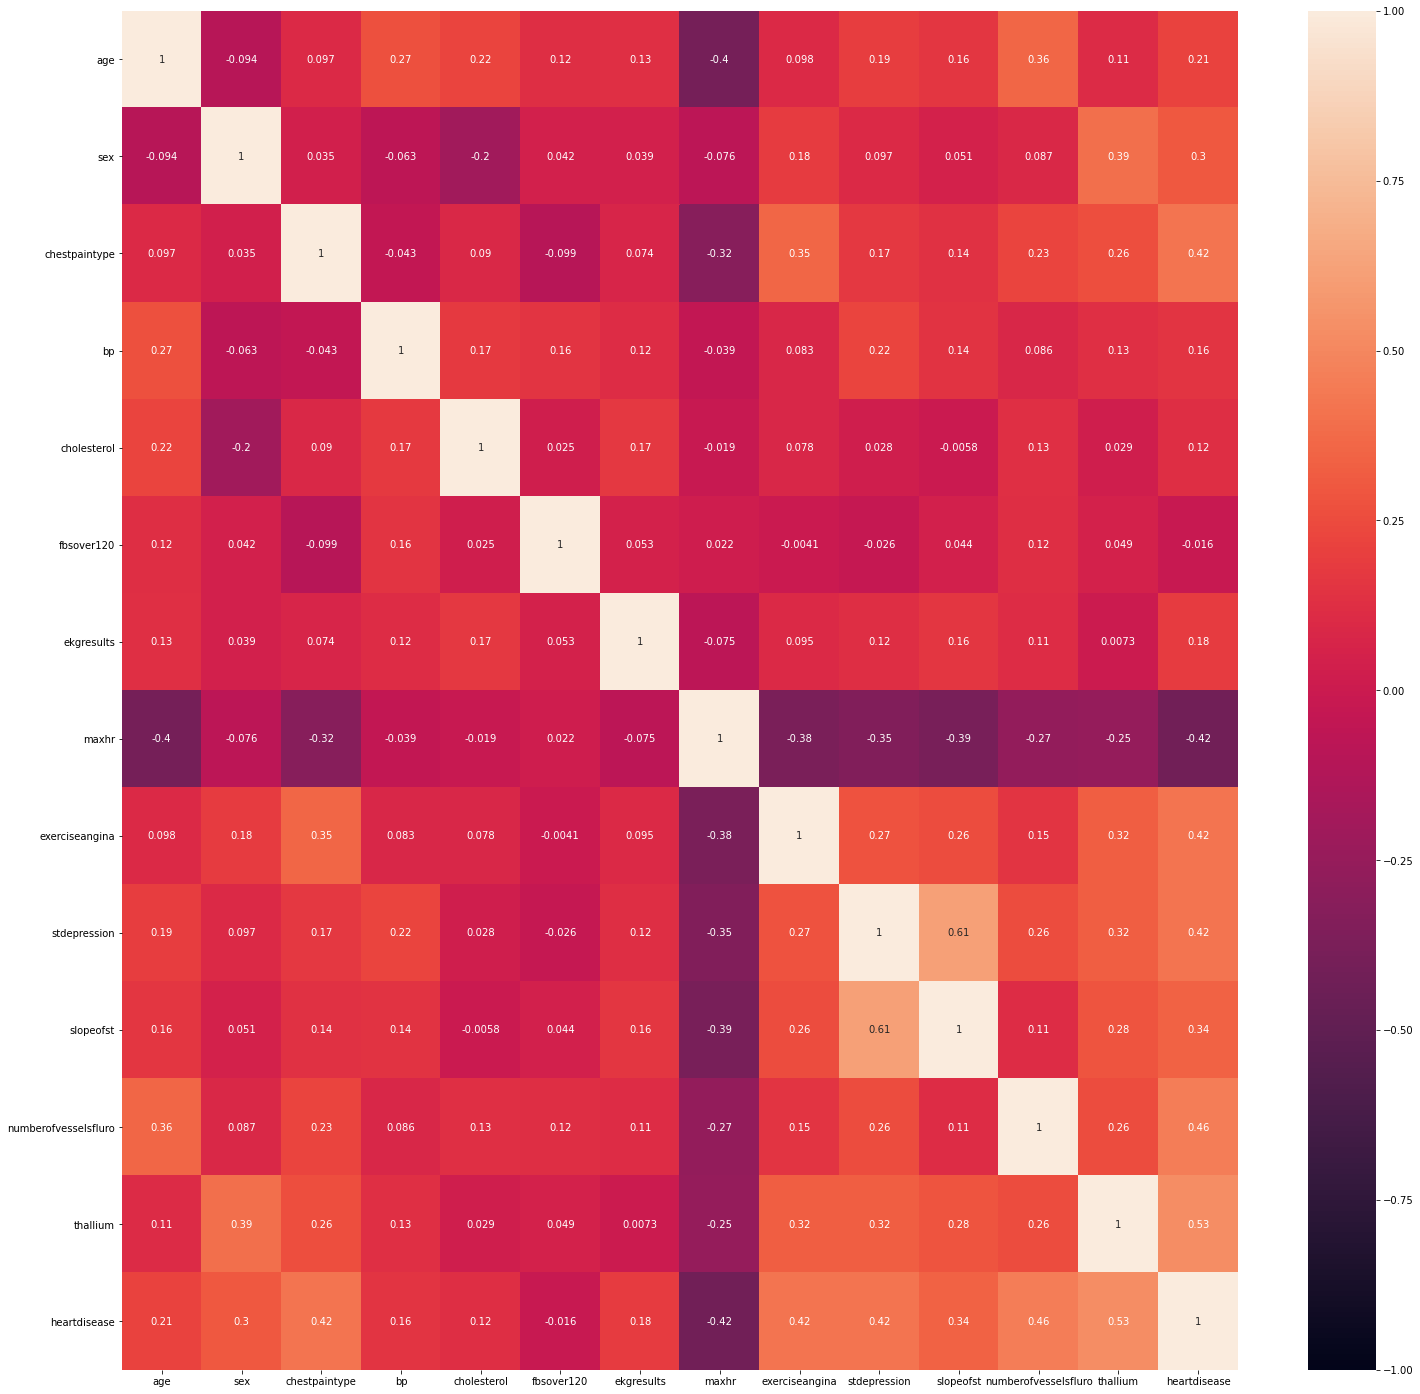

In [5]:
corr_matrix = df.corr()

plt.figure(figsize=(25,25))
sns.heatmap(corr_matrix, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

# 3. Split df into Features, Target, then into Train and Test datasets

In [6]:
# create target vector and feature matrix and rescale
y = df.heartdisease
X = df.drop(['heartdisease','fbsover120'], axis=1)
#X = df.drop(['heartdisease','bp','cholesterol','fbsover120'], axis=1)  
     ## with and without these weak features give same performance, so include features for model training
    
# rescale in df for checking density profile of continuous/non-categorial predictors
X.age = minmax_scale(X.age)
X.bp = minmax_scale(X.bp)
X.maxhr = minmax_scale(X.maxhr)
X.cholesterol = minmax_scale(X.cholesterol)

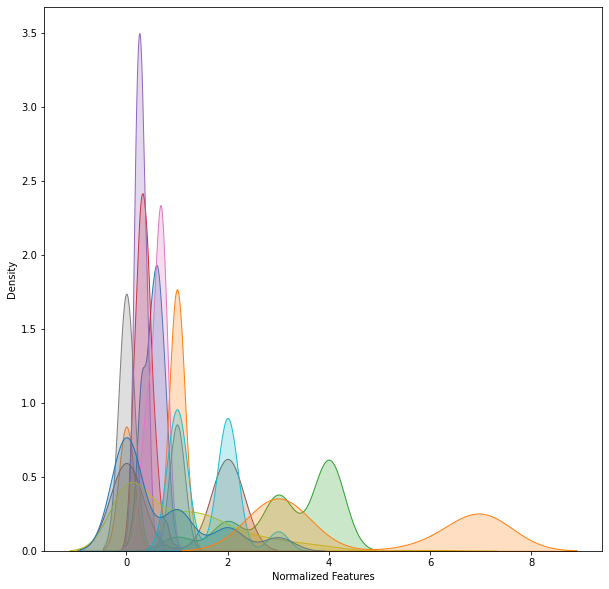

In [7]:
plt.figure(figsize=(10,10))
a = list(X.columns)
#a = list(df.columns)
#a.remove('heartdisease')
for i in a:
    sns.kdeplot(X[i], shade=True)
plt.xlabel('Normalized Features')
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=ranstate)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(189, 12)
(189,)
(81, 12)
(81,)


# 4. Building Model and Making Predictions

In [10]:
## codes are adopted from ref [3] and modified for addons

# Import the classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(random_state=ranstate), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(random_state=ranstate),
               RandomForestClassifier(random_state=ranstate)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers','fpr','tpr','auc','prec','recl','aps','ypred','yproba'])

# Train the models and store the results into df
for clf in classifiers:
    model = clf.fit(X_train, y_train)
    
    # calc prediction and probability of predicting labels
    ypred = model.predict(X_test)
    yproba = model.predict_proba(X_test)[::,1]
    
    # calc fpr and tpr for roc_curve
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = round(roc_auc_score(y_test, yproba), 4)
    
    # calc precision and recall for PRcurve
    prec, recl, treshold = precision_recall_curve(y_test, yproba)
    aps = average_precision_score(y_test, ypred)
    
    result_table = result_table.append({'classifiers':clf.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'prec':prec,
                                        'recl':recl,
                                        'aps':aps,
                                        'ypred':ypred,
                                        'yproba':yproba}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

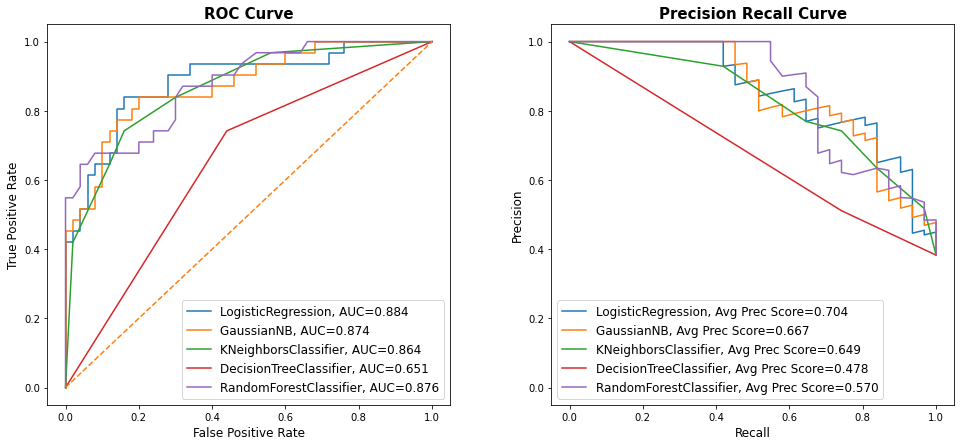

In [11]:
# Plot figure and subplots
fig = plt.figure(figsize=[14,7])

gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.45, wspace=0.05)   
ax1 = fig.add_subplot(gs1[0, 0])
for i in result_table.index:
    ax1.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
ax1.plot([0, 1], [0, 1], color = 'C1', linestyle='--')
ax1.set_title('ROC Curve', fontsize=15, fontweight='semibold')
ax1.set_xlabel('False Positive Rate', fontsize=12); ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_xlim([-0.05,1.05]); ax1.set_ylim([-0.05,1.05]); 
ax1.legend(prop={'size':12}, loc='lower right')

gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.55, right=0.95, wspace=0.05)
ax2 = fig.add_subplot(gs2[0, 0])
for i in result_table.index:
    ax2.plot(result_table.loc[i]['recl'], 
             result_table.loc[i]['prec'], 
             label="{}, Avg Prec Score={:.3f}".format(i, result_table.loc[i]['aps']))
ax2.set_title('Precision Recall Curve', fontsize=15, fontweight='semibold')
ax2.set_xlabel('Recall', fontsize=12); ax2.set_ylabel('Precision', fontsize=12)
ax2.set_xlim([-0.05,1.05]); ax2.set_ylim([-0.05,1.05])
ax2.legend(prop={'size':12}, loc='lower left')

plt.show()

# 5. Test Some Feature Aggregations on Performance Metrics of Logistic Regression Model

## 5.1. Create Some Additional Features by Aggregating Feature(s)

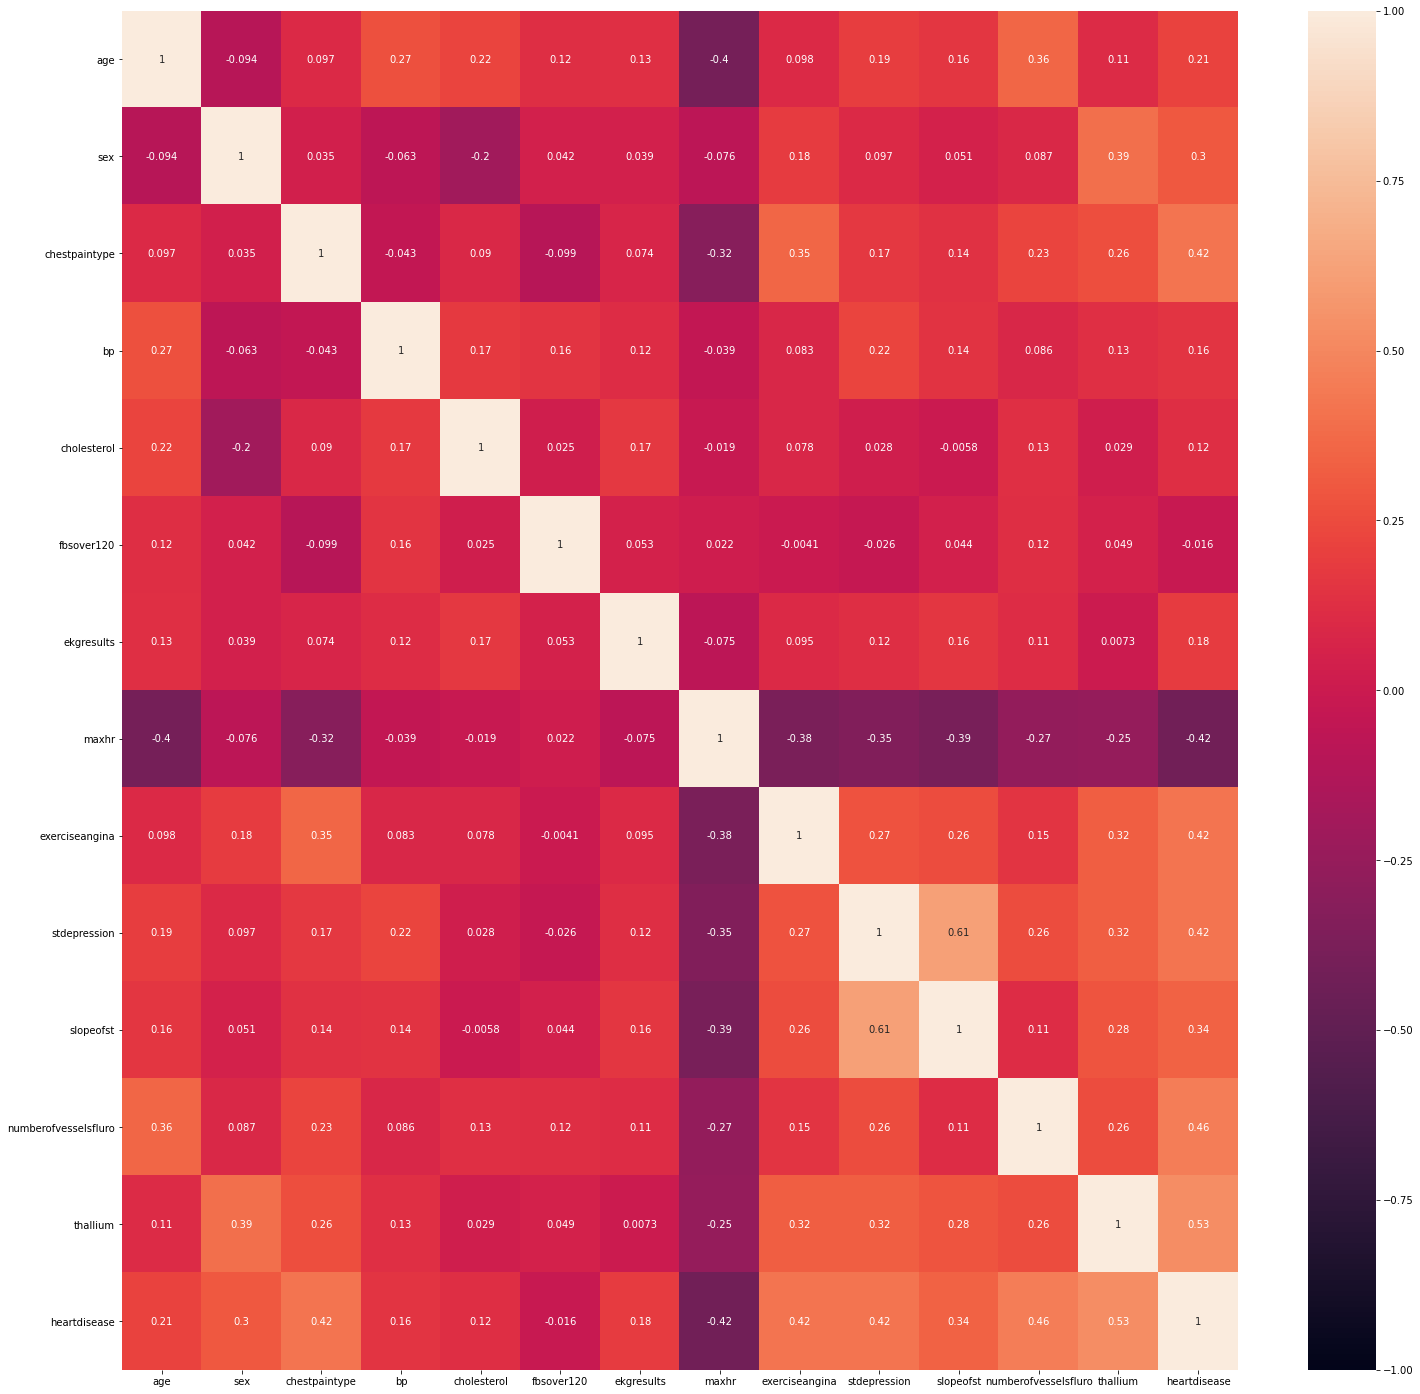

In [12]:
corr_matrix = df.corr()

plt.figure(figsize=(25,25))
sns.heatmap(corr_matrix, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

### Important observations from correlation matrix:
* All predictors for heartdisease risk is <0.5, except thallium, which is barely 0.5 the max scale for predictive strength.
* Stronger predictors for heartdisease (corr>0.4) ranks as follow:
  __Thallium > numberofvesselsfluro > exerciseangina > stdepression > chestpaintype__ > slopeofst > sex > age > ekgresults > bp > cholesterol > (fbsover120) > (maxhr).
  (neg predictor)
* The __top5 predictors__ are all >0.4 --> grouped together as product aggregate (col n1) or averaged sum with correlation coeff (col n2).
* The next 6 predictors are lumped as product divided by the negative predictors
  
  

In [13]:
# create df_eng matrix permutations
df_eng = pd.DataFrame()

df_eng['n1'] = df.thallium * df.numberofvesselsfluro * df.exerciseangina * df.stdepression * df.chestpaintype
df_eng['n2'] = ( (0.53*df.thallium + 0.46*df.numberofvesselsfluro + 0.42*df.exerciseangina + 0.42*df.stdepression + 0.42*df.chestpaintype)/2.25)

df_eng['n3'] = df.slopeofst * df.sex * df.age * df.ekgresults * df.bp * df.cholesterol 
df_eng['n4'] = ( (0.34*df.slopeofst + 0.3*df.sex + 0.21*df.age + 0.18*df.ekgresults + 0.16*df.bp + 0.12*df.cholesterol)/(1.31) )

## aggregate both negative predictors
df_eng['n5'] = df.fbsover120 * df.maxhr
                
## factor pos pred with neg predictors
df_eng['n6'] = df_eng.n1/df.maxhr
#df_eng['n7'] = df_eng.n1/df.fbsover120
#df_eng['n8'] = df_eng.n1/df_eng.n5
                
df_eng['n9'] = df_eng.n2/df.maxhr
#df_eng['n10'] = df_eng.n2/df.fbsover120
#df_eng['n11'] = df_eng.n2/df_eng.n5

df_eng['n12'] = df_eng.n3/df.maxhr
#df_eng['n13'] = df_eng.n3/df.fbsover120
#df_eng['n14'] = df_eng.n3/df_eng.n5

df_eng['n13'] = df_eng.n4/df.maxhr
#df_eng['n14'] = df_eng.n4/df.fbsover120
#df_eng['n15'] = df_eng.n4/df_eng.n5

df_eng['n16'] = df_eng.n1*df_eng.n4/df.maxhr

df_eng['heartdisease'] = df.heartdisease

df_eng = df_eng.fillna(0)
df_eng.head(10)

,n1,n2,n3,n4,n5,n6,n9,n12,n13,n16,heartdisease
0,0.0,2.514667,11720800,57.618321,0,0.000000,0.023070,107530.275229,0.528608,0.000000,1
1,0.0,2.507556,0,77.244275,0,0.000000,0.015672,0.000000,0.482777,0.000000,0
2,0.0,2.078222,0,48.679389,0,0.000000,0.014739,0.000000,0.345244,0.000000,1
3,5.6,2.824000,0,50.732824,0,0.053333,0.026895,0.000000,0.483170,2.705751,0
4,1.2,1.508444,0,51.694656,0,0.009917,0.012466,0.000000,0.427229,0.512674,0
5,0.0,2.470222,0,41.778626,0,0.000000,0.017644,0.000000,0.298419,0.000000,0
6,10.8,2.476444,7454720,49.328244,142,0.076056,0.017440,52498.028169,0.347382,3.751726,1
7,33.6,3.010667,6204440,45.809160,0,0.236620,0.021202,43693.239437,0.322600,10.839351,1
8,0.0,3.028444,9844800,54.580153,0,0.000000,0.017814,57910.588235,0.321060,0.000000,1
9,0.0,3.755556,0,66.496183,0,0.000000,0.024387,0.000000,0.431793,0.000000,1


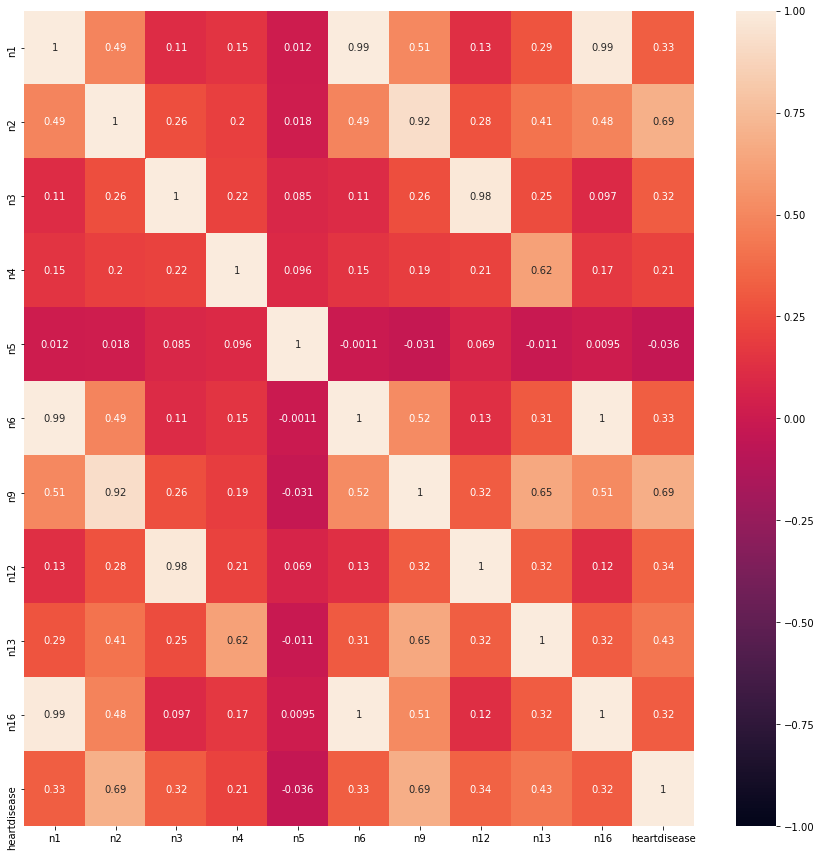

In [14]:
# check how aggregated feats are correlated to heartdisease risk 
corr_matrix2 = df_eng.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix2, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

In [15]:
# create target vector and feature matrix and rescale
y = df.heartdisease
X = df.drop(['heartdisease','fbsover120'], axis=1)
#X = df.drop(['heartdisease','bp','cholesterol','fbsover120'], axis=1)  
     ## with and without these weak features give same performance, so include features for model training

# rescale in df for checking density profile of continuous/non-categorial predictors
X.age = minmax_scale(X.age)
X.bp = minmax_scale(X.bp)
X.maxhr = minmax_scale(X.maxhr)
X.cholesterol = minmax_scale(X.cholesterol)

In [16]:
# Feature aggregation didn't really affect performance metrics, 
    ### hence none of the aggregated feats were included into model training

#X['n13'] = minmax_scale(df_eng.n13)
#X['n3'] = minmax_scale(df_eng.n3)

['age', 'sex', 'chestpaintype', 'bp', 'cholesterol', 'ekgresults', 'maxhr', 'exerciseangina', 'stdepression', 'slopeofst', 'numberofvesselsfluro', 'thallium']


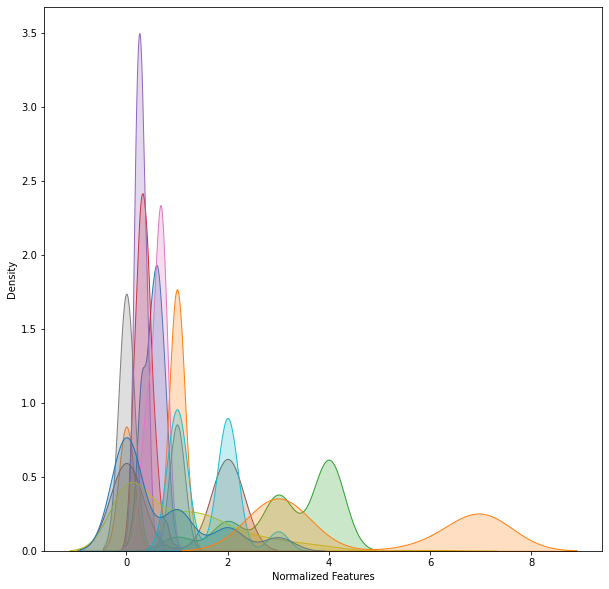

In [17]:
plt.figure(figsize=(10,10))
a = list(X.columns)
print(a)
for i in a:
    sns.kdeplot(X[i], shade=True)
plt.xlabel('Normalized Features')
plt.show()

## 5.2. Re-train Logistic Regression Model after feature aggregation analysis

In [18]:
lm = LogisticRegression()
lm.fit(X_train, y_train)

LogisticRegression()

In [19]:
y_predLR = lm.predict(X_test)
y_probaLR = lm.predict_proba(X_test)
np.mean(y_predLR == y_test)

0.8395061728395061

In [20]:
print(classification_report(y_test,y_predLR))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        50
           1       0.78      0.81      0.79        31

    accuracy                           0.84        81
   macro avg       0.83      0.83      0.83        81
weighted avg       0.84      0.84      0.84        81



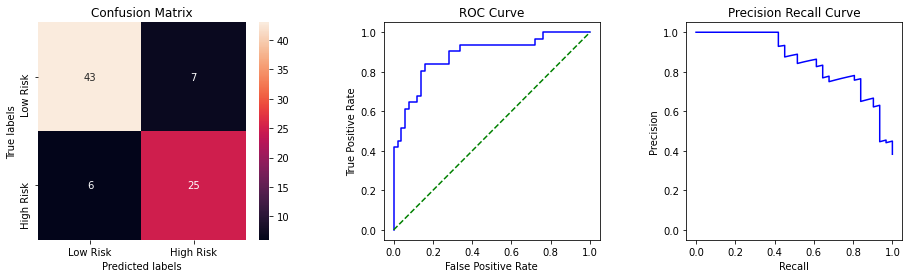

In [21]:
# confusion matrix calc
cm = confusion_matrix(y_test, y_predLR)

# ROC curve calc
fpr, tpr, _ = roc_curve(y_test, y_probaLR[:,1])

# Precision Recall curve calc
prec, recl, treshold = precision_recall_curve(y_test, y_probaLR[:,1])

# Plot figure and subplots
fig = plt.figure(figsize=[12,4])

gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.35, wspace=0.05)    
ax1 = fig.add_subplot(gs1[0, 0])
sns.heatmap(cm, annot=True, fmt='g', ax=ax1)
ax1.set_xlabel('Predicted labels');ax1.set_ylabel('True labels'); 
ax1.set_title('Confusion Matrix')
ax1.xaxis.set_ticklabels(['Low Risk', 'High Risk']); ax1.yaxis.set_ticklabels(['Low Risk', 'High Risk'])

gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.45, right=0.7, wspace=0.1)
ax2 = fig.add_subplot(gs2[0, 0])
ax2.plot(fpr,tpr, color = 'b')
ax2.plot([0, 1], [0, 1], color = 'g', linestyle='--')
ax2.set_title('ROC Curve')
ax2.set_xlabel('False Positive Rate'); ax2.set_ylabel('True Positive Rate')
ax2.set_xlim([-0.05,1.05]); ax2.set_ylim([-0.05,1.05])

gs3 = fig.add_gridspec(nrows=1, ncols=1, left=0.8, right=1.05, wspace=0.15)
ax3 = fig.add_subplot(gs3[0, 0])
ax3.plot(recl,prec,  color = 'b')
ax3.set_title('Precision Recall Curve')
ax3.set_xlabel('Recall'); ax3.set_ylabel('Precision')
ax3.set_xlim([-0.05,1.05]); ax3.set_ylim([-0.05,1.05])

plt.show()


* Model is ~86% (43/50) accurate in predicting no event, but still need improvement to predict event ~80% (25/31).
* Aggregating feature(s) doesn't change the model performance. 

# 6. References
1. Dataset source: https://www.kaggle.com/datasets/thedevastator/predicting-heart-disease-risk-using-clinical-var
2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/pdf/pone.0118432.pdf
3. https://www.imranabdullah.com/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot
